# Solutions 7
Maximum Likelihood method

In [205]:
from __future__ import print_function
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.stats import norm, chi2, lognorm

In [151]:
measurements = np.array([97.8621, 114.105, 87.7593, 93.2134, 86.6624, 87.4629, 79.7712, \
91.5024, 87.7737, 89.6926, 133.506, 91.4124, 94.4401, 97.3968, \
108.424, 103.197, 88.2166, 142.217, 89.0393, 102.438, 95.7987, \
94.5177, 96.8171, 90.903, 132.463, 92.3394, 84.1451, 87.3447, \
92.2861, 84.4213, 124.017, 90.4941, 95.7992, 92.3484, 95.9813, \
88.0641, 101.002, 97.7268, 137.379, 96.213, 140.795, 99.9332, \
130.087, 108.839, 90.0145, 100.313, 87.5952, 92.995, 114.457, \
90.7526, 112.181, 117.857, 95.2804, 115.922, 117.043, 104.317, \
126.728, 87.8592, 89.9614, 100.377, 107.38, 88.8426, 93.3224, \
138.947, 102.288, 123.431, 114.334, 88.5134, 124.7, 87.7316, 84.7141, \
91.1646, 87.891, 121.257, 92.9314])

## 1-D Maximum likelihood fit

We have a set of measurements which are distributed according to the sum of two Gaussians (e.g. this can be signal and background).

$\rho = \frac{1}{3}\frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2}\left(\frac{x-p}{\sigma}\right)^2} + \frac{2}{3}\frac{1}{\sqrt{2\pi \sigma_b^2}} e^{-\frac{1}{2}\left(\frac{x-p_b}{\sigma_b}\right)^2}$  

where for one of the two peaks the parameters are known already

$p_b = 91.0$  
$\sigma_b = 5.0$  
  

In [228]:
def likelihood_point(x, position, width):
    return 1.0/3/np.sqrt(2*np.pi*width**2)*np.exp(-0.5*((x-position)/(width))**2.0) + 2.0/3/np.sqrt(2*np.pi*5**2)*np.exp(-0.5*((x-91)/(5))**2.0)

First, we assume the width of the peak we want to fit is already known: $\sigma = 15.0$.
Perform a 1-D Maximum Likelihood fit for the position of the peak $p$.

Complete the functions below which return the likelihood and negative log likelihood (NLL).

In [347]:
def likelihood_1d(params):
    return np.prod([likelihood_point(x, params[0], 15.0) for x in measurements])

def nll_1d(params):
    return -np.log(likelihood_1d(params))

Minimize the NLL and give the best-fit result, including asymetric errors and plot the NLL.

position: 117.72333147980623
negative error: [3.31211666]
positive error: [3.39091994]


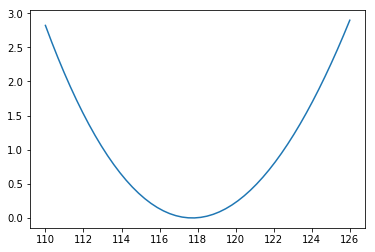

In [355]:
solution = minimize(nll_1d, [100.0], method='CG')
min_pos = solution.x[0]
min0 = solution.fun
scan_points = np.linspace(110.0,126.0,50)
plt.plot(scan_points, [nll_1d([x]) - min0 for x in scan_points])

nll_1sigma = lambda x: nll_1d([x]) - min0 - 0.5
print("position:", min_pos)
print("negative error:", min_pos - fsolve(nll_1sigma, min_pos-0.5))
print("positive error:", fsolve(nll_1sigma, min_pos+0.5) - min_pos)
plt.show()

## 2-D Likelihood fit

Now we perform the 2-D Maximum Likelihood fit, fitting for both $\sigma$ and $p$ at the same time.

In [350]:
def likelihood(params):
    return np.prod([likelihood_point(x, params[0], params[1]) for x in measurements])

def nll(params):
    return -np.log(likelihood(params))

Minimize the NLL and find the best-fit result.

In [353]:
solution = minimize(nll, [120.0, 10], method='CG')
print("position:", solution.x[0], "width:", solution.x[1])

position: 118.31548192622421 width: 13.629783202046086


Create a 2D contour plot of the 1, 2 and 3 $\sigma$ contours of the NLL and plot the best-fit solution.

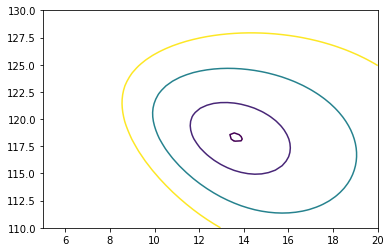

In [354]:
scanA = np.linspace(110.0,130.0,50)
scanB = np.linspace(5,20,50)
minValue = nll(solution.x)
Z = [[nll([a,b]) - minValue for b in scanB] for a in scanA]
p1 = plt.contour(scanB, scanA, Z, [0.01,0.5, 2.0, 4.5])

Compute numerically the error matrix of the NLL for the 2-D fit.

In [301]:
from scipy.misc import derivative

# compute the error matrix
A = np.linalg.inv([
    [
        derivative(lambda x: nll([x, solution.x[1]]), solution.x[0], n=2),
        derivative(lambda y: derivative(lambda x: nll([x, y]), solution.x[0]), solution.x[1])
    ],
    [
        derivative(lambda x: derivative(lambda y: nll([x, y]), solution.x[1]), solution.x[0]),
        derivative(lambda y: nll([solution.x[0], y]), solution.x[1], n=2)
    ]
])
print(A, "\nsigma(position):", np.sqrt(A[0,0]), "sigma(width):", np.sqrt(A[1,1]))

[[11.95694692 -3.06065748]
 [-3.06065748  5.72672173]] 
sigma(position): 3.4578818544955507 sigma(width): 2.3930569834299082


## Binned ML fit

With the same data as above, we now perform a binned ML fit and compare with the unbinned fit.
First, create a histogram of the data using np.histogram.

In [374]:
nBins = 10
histoMax = 170
histoMin = 70
binWidth = (histoMax-histoMin)/nBins
h0 = np.histogram(measurements, bins=nBins, range=(histoMin, histoMax))
print(h0[0])
print(h0[1])

[ 1 19 26 10  7  5  5  2  0  0]
[ 70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.]


Compute the binned NLL:

In [375]:
def nll_binned(params):
    # params is a list of [position, sigma]
    expected = [likelihood_point(x+binWidth/2, params[0], params[1])*(binWidth/2)*sum(h0[0]) for x in h0[1]]
    return sum([-np.log(expected[i]**h0[0][i]) for i in range(nBins)])

Minimize the binned NLL:

In [376]:
solution_binned=minimize(nll_binned, [120.0, 10], method='CG')
print(solution_binned)

     fun: -138.93433719876123
     jac: array([-1.90734863e-06,  1.90734863e-06])
 message: 'Optimization terminated successfully.'
    nfev: 60
     nit: 6
    njev: 15
  status: 0
 success: True
       x: array([116.43876363,  15.33581135])


Make a contour plot of the 1,2, and 3 $\sigma$ contours for the binned NLL and overlay it with the unbinned contours.

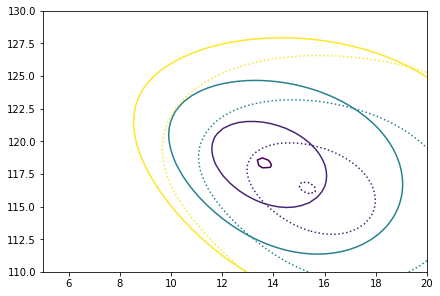

In [377]:
scanA = np.linspace(110.0,130.0,50)
scanB = np.linspace(5,20,50)
Z_binned = [[nll_binned([a,b]) - solution_binned.fun for b in scanB] for a in scanA]

fig1, ax2 = plt.subplots(constrained_layout=True)

p1 = ax2.contour(scanB, scanA, Z, [0.01,0.5, 2.0, 4.5])
p2 = ax2.contour(scanB, scanA, Z_binned, [0.01,0.5, 2.0, 4.5], linestyles="dotted")
plt.show()

Repeat the same for 50 bins:

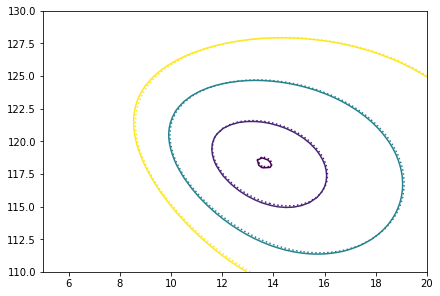

In [373]:
scanA = np.linspace(110.0,130.0,50)
scanB = np.linspace(5,20,50)
Z_binned = [[nll_binned([a,b]) - solution_binned.fun for b in scanB] for a in scanA]

fig1, ax2 = plt.subplots(constrained_layout=True)

p1 = ax2.contour(scanB, scanA, Z, [0.01,0.5, 2.0, 4.5])
p2 = ax2.contour(scanB, scanA, Z_binned, [0.01,0.5, 2.0, 4.5], linestyles="dotted")
plt.show()